In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
from open_clip import create_model_from_pretrained, get_tokenizer

In [2]:
model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP')
tokenizer = get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_text_embeddings(descriptions: list[str]):
    text_tokens = tokenizer(descriptions).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu().numpy()
    return text_features

cap3D = pd.read_csv('cap3D_test_set.csv')
cap3D['theme'] = cap3D['theme'].str.replace(' ', '')
cap3D['shape'] = cap3D['shape'].str.replace(' ', '')
cap3D = cap3D[~cap3D.isna().any(axis=1)]
cap3D

,Unnamed: 0,uid,caption,category,color,material,theme,shape
0,0,ed51a51909ee46c780db3a85e821feb2,A green and white rifle.,rifle,Green,Metal,Military,Rectangular
1,1,9110b606f6c547b2980fcb3c8c4b6a1c,"a small building with a roof, accompanied by b...",house,Brown,Wood,Rustic,Rectangular
2,2,80d9caaa1fa04502af666135196456e1,a pair of purple and black swords with white h...,sword,Multicolor,Metal,Oriental,Symmetrical
3,3,28d43a218cd8466a8c1f82b29b71e314,"a small house, island, road with trash, trash ...",island,Multicolored,Mixed,Environmental,Irregular
4,4,75582285fab442a2ba31733f9c8fae66,"a small, grassy hill.",hill,Green,Earth,Nature,Mound
...,...,...,...,...,...,...,...,...
9971,9994,3a0f68d68e0e426780fbe2da8ca06de8,A plaque featuring a star and city name.,plaque,Black,Metal,Urban,Rectangle
9972,9995,aae70af3556d468795220ece999901eb,a wooden bench with a pair of handrails and ra...,bench,Brown,Wood,N/A,Rectangular
9973,9996,e383772896c44539b6a14591be784472,Small blue object with various interpretations...,ambiguous,Blue,N/A,N/A,N/A
9974,9997,bda253a8f4d444bc81c43d0dc9168c8e,a man with purple hair,human,Purple,N/A,N/A,N/A


In [3]:
len(cap3D['color'].unique()) + len(cap3D['material'].unique()) + len(cap3D['theme'].unique()) + len(cap3D['shape'].unique())

1277

In [4]:
def create_similarity_label_dict(feature: str, labels: list[str]):
    similarity_dict = {}
    tags = cap3D[feature].unique().tolist()
    label_embeddings = get_text_embeddings(labels)
    tag_embeddings = get_text_embeddings(tags)
    similarities = label_embeddings @ tag_embeddings.T # CLIP Score array of shape n labels x m tags
    for j, tag in enumerate(tags):
        tag_similarities = [similarities[i][j] for i in range(len(labels))] # getting n similarities for jth tag
        similarity_dict[tag] = labels[np.argmax(tag_similarities)]
    return similarity_dict

def create_feature_dict(features):
    feature_dict = {}
    for feature, labels in features.items():
        feature_dict[feature] = create_similarity_label_dict(feature, labels)
    return feature_dict   

shape_theme_material_color = {
    'shape': ['Cuboid', 'Sphere', 'Cone', 'Cylinder'],
    'theme': ['Nature', 'Culture', 'Fantasy', 'Modern'],
    'material': ['Wood', 'Metal', 'Stone', 'Plastic'],
    'color': ['Yellow', 'Red', 'Blue', 'Gray','Multicolor']
}
                                      
stmc = create_feature_dict(shape_theme_material_color)
                               

cap3D2 = cap3D.assign(color_clip = cap3D['color'].apply(lambda x: stmc['color'][x]),
                      material_clip = cap3D['material'].apply(lambda x: stmc['material'][x]),
                      theme_clip = cap3D['theme'].apply(lambda x: stmc['theme'][x]),
                      shape_clip = cap3D['shape'].apply(lambda x: stmc['shape'][x]))

cap3D2

,Unnamed: 0,uid,caption,category,color,material,theme,shape,color_clip,material_clip,theme_clip,shape_clip
0,0,ed51a51909ee46c780db3a85e821feb2,A green and white rifle.,rifle,Green,Metal,Military,Rectangular,Yellow,Metal,Nature,Cuboid
1,1,9110b606f6c547b2980fcb3c8c4b6a1c,"a small building with a roof, accompanied by b...",house,Brown,Wood,Rustic,Rectangular,Red,Wood,Modern,Cuboid
2,2,80d9caaa1fa04502af666135196456e1,a pair of purple and black swords with white h...,sword,Multicolor,Metal,Oriental,Symmetrical,Multicolor,Metal,Modern,Sphere
3,3,28d43a218cd8466a8c1f82b29b71e314,"a small house, island, road with trash, trash ...",island,Multicolored,Mixed,Environmental,Irregular,Multicolor,Stone,Nature,Sphere
4,4,75582285fab442a2ba31733f9c8fae66,"a small, grassy hill.",hill,Green,Earth,Nature,Mound,Yellow,Stone,Nature,Cone
...,...,...,...,...,...,...,...,...,...,...,...,...
9971,9994,3a0f68d68e0e426780fbe2da8ca06de8,A plaque featuring a star and city name.,plaque,Black,Metal,Urban,Rectangle,Gray,Metal,Modern,Cuboid
9972,9995,aae70af3556d468795220ece999901eb,a wooden bench with a pair of handrails and ra...,bench,Brown,Wood,N/A,Rectangular,Red,Wood,Nature,Cuboid
9973,9996,e383772896c44539b6a14591be784472,Small blue object with various interpretations...,ambiguous,Blue,N/A,N/A,N/A,Blue,Stone,Nature,Sphere
9974,9997,bda253a8f4d444bc81c43d0dc9168c8e,a man with purple hair,human,Purple,N/A,N/A,N/A,Red,Stone,Nature,Sphere


In [5]:
# import os
# import base64
# import requests
# from io import BytesIO

# # Get OpenAI API Key from environment variable
# api_key = ...
# headers = {
#     "Content-Type": "application/json",
#     "Authorization": f"Bearer {api_key}"
# }

# metaprompt = '''
# - You are an expert interior layout designer that follows instructions.
# '''    

# # Function to encode the image
# def encode_image_from_file(image_path):
#     with open(image_path, "rb") as image_file:
#         return base64.b64encode(image_file.read()).decode('utf-8')

# def encode_image_from_pil(image):
#     buffered = BytesIO()
#     image.save(buffered, format="JPEG")
#     return base64.b64encode(buffered.getvalue()).decode('utf-8')

# def prepare_inputs(message, image=None):

#     # # Path to your image
#     # image_path = "temp.jpg"
#     # # Getting the base64 string
#     # base64_image = encode_image(image_path)
    
#     if image:
#         base64_image = encode_image_from_file(image)
#         payload = {
#             "model": "gpt-4-vision-preview",
#             "messages": [
#             {
#                 "role": "system",
#                 "content": [
#                     metaprompt
#                 ]
#             }, 
#             {
#                 "role": "user",
#                 "content": [
#                 {
#                     "type": "text",
#                     "text": message, 
#                 },
#                 {
#                     "type": "image_url",
#                     "image_url": {
#                     "url": f"data:image/jpeg;base64,{base64_image}"
#                     }
#                 }
#                 ]
#             }
#             ],
#             "max_tokens": 2000
#         }
#     else:
#         payload = {
#             "model": "gpt-4-1106-preview",
#             "messages": [
#             {
#                 "role": "system",
#                 "content":
#                     metaprompt
#             }, 
#             {
#                 "role": "user",
#                 "content": message,
#             }
#             ],
#             "max_tokens": 2000
#         }

#     return payload

# def request_gpt4v(message, image):
#     payload = prepare_inputs(message, image)
#     response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
# #     print(response.json())
#     res = response.json()['choices'][0]['message']['content']
#     return res

# def request_gpt4turbo(message):
#     payload = prepare_inputs(message)
#     response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
# #     print(response.json())
#     res = response.json()['choices'][0]['message']['content']
#     return res

#  features = cap3D.columns[4:]
# for feature in features:
#     feature_arr = cap3D[feature].unique().tolist()
#     condense_categories = f"""
#     Instructions: You will be given a list of {feature}s describing 3D objects. A lot of the labels are similar to each other in the list, and you want to condense the list into 3-5 comprehensive labels. Return a python list of the comprehensive labels.

#     Prompt: Condense the list below into 3-5 comprehensive labels and return a python list containing them.

#     {feature_arr}

#     Output: 

#     """
#     print(f'{feature}:', eval(extract_python_code(request_gpt4turbo(condense_categories))))

In [6]:
with open('embeddings_SigLIP.pkl', 'rb') as f:
    image_embeddings = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [7]:
cap3D_uids = cap3D['uid'].tolist()
# Function to generate text embeddings
def get_text_embeddings(descriptions):
    text_tokens = tokenizer(descriptions).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu().numpy()
    return text_features

# Function for object retrieval
def retrieve_objects(query):
    # Generate text embedding for the query
    query_embedding = get_text_embeddings([query])
    
    new_embeddings = np.array([image_embeddings[uid]['image_feature'] for uid in cap3D_uids])
    new_embeddings = new_embeddings[:,0,:]
    uid_embeddings = [uid for uid in cap3D_uids]
    
    # Calculate similarity between query embedding and dataset embeddings
    similarities = list(query_embedding @ new_embeddings.T)[0]
    
    grouped_similarities = [(x,y) for x,y in zip(uid_embeddings,similarities)]
    # Rank images based on similarity
    ranked_indices = sorted(grouped_similarities, key=lambda x: x[1],reverse=True)
    
    # Retrieve top results 
    top_results = ranked_indices[:10]  # gather top 10 most similar objects
    return top_results


# Example query
query = "Cat"

# Perform object retrieval
results = retrieve_objects(query)
print(results)

[('d6b0bf73a0d849d08c929f1f7af00805', 0.08209121), ('14cf75cbafcf4a5da3f22067565a821c', 0.080240354), ('6d0eaa4145774c5fb254dcb759d5b29e', 0.07448015), ('2144c95689d84d50b5db84ac361b7d2d', 0.07421865), ('e0a5908bd44e42a4a08afe1ddf43662d', 0.073333874), ('a48202eca385476cafb03a1ed395f2b2', 0.07217847), ('29ecbb4d17c34375b007a3ca4f2f6586', 0.071742706), ('a2c05c8d42194feabc3ad761f15495ec', 0.07003607), ('118f19a1e9a1479285a3141c0d1f9b3f', 0.06881329), ('e8861a671c3245f0a5a9ff54b7c75e91', 0.067618094)]


In [8]:
def get_all_top_tens(uid_list):
    all_rankings = {}
    for uid in uid_list:
        caption = cap3D.loc[cap3D['uid'] == uid, 'caption']
        top_ten = retrieve_objects(caption.iloc[0])
        all_rankings[uid] = top_ten
    return all_rankings    

rankings = get_all_top_tens(cap3D['uid'])

In [10]:
def evaluate_clip(all_objects):
    results = {}
    for uid in all_objects:
        compare_color = []
        compare_theme = []
        compare_shape = []
        compare_material = []
        precision = []
        ranking = all_objects[uid]
        gt_row = cap3D.loc[cap3D['uid'] == uid]
        for i in [1, 3, 5, 10]:
            top_i_df = cap3D.loc[cap3D['uid'].isin([x[0] for x in ranking][:i])]
            compare_color.append((i, np.sum(top_i_df['color'] == gt_row['color'].iloc[0])))
            compare_theme.append((i, np.sum(top_i_df['theme'] == gt_row['theme'].iloc[0])))
            compare_shape.append((i, np.sum(top_i_df['shape'] == gt_row['shape'].iloc[0])))
            compare_material.append((i, np.sum(top_i_df['material'] == gt_row['material'].iloc[0])))
            precision.append((i, uid in top_i_df['uid'].to_list()))
        results[uid] = {'color':compare_color,'theme':compare_theme,
                        'shape':compare_shape,'material':compare_material,'gt_retrieved':precision}
    return results

clip_evaluations = evaluate_clip(rankings)

In [11]:
cap3D_results = cap3D.assign(color_clip = cap3D['uid'].apply(lambda uid: clip_evaluations[uid]['color'][-1][1]),
                      material_clip = cap3D['uid'].apply(lambda uid: clip_evaluations[uid]['material'][-1]),
                      theme_clip = cap3D['uid'].apply(lambda uid: clip_evaluations[uid]['theme'][-1][1]),
                      shape_clip = cap3D['uid'].apply(lambda uid: clip_evaluations[uid]['shape'][-1][1]),
                      gt_retrieved_clip = cap3D['uid'].apply(lambda uid: clip_evaluations[uid]['gt_retrieved'][-1][1]))
cap3D_results

,Unnamed: 0,uid,caption,category,color,material,theme,shape,color_clip,material_clip,theme_clip,shape_clip,gt_retrieved_clip
0,0,ed51a51909ee46c780db3a85e821feb2,A green and white rifle.,rifle,Green,Metal,Military,Rectangular,3,"(10, 6)",8,4,True
1,1,9110b606f6c547b2980fcb3c8c4b6a1c,"a small building with a roof, accompanied by b...",house,Brown,Wood,Rustic,Rectangular,5,"(10, 7)",3,9,False
2,2,80d9caaa1fa04502af666135196456e1,a pair of purple and black swords with white h...,sword,Multicolor,Metal,Oriental,Symmetrical,5,"(10, 8)",1,1,True
3,3,28d43a218cd8466a8c1f82b29b71e314,"a small house, island, road with trash, trash ...",island,Multicolored,Mixed,Environmental,Irregular,4,"(10, 4)",1,7,True
4,4,75582285fab442a2ba31733f9c8fae66,"a small, grassy hill.",hill,Green,Earth,Nature,Mound,9,"(10, 1)",6,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9971,9994,3a0f68d68e0e426780fbe2da8ca06de8,A plaque featuring a star and city name.,plaque,Black,Metal,Urban,Rectangle,1,"(10, 1)",2,3,True
9972,9995,aae70af3556d468795220ece999901eb,a wooden bench with a pair of handrails and ra...,bench,Brown,Wood,N/A,Rectangular,6,"(10, 5)",6,8,True
9973,9996,e383772896c44539b6a14591be784472,Small blue object with various interpretations...,ambiguous,Blue,N/A,N/A,N/A,8,"(10, 7)",8,2,False
9974,9997,bda253a8f4d444bc81c43d0dc9168c8e,a man with purple hair,human,Purple,N/A,N/A,N/A,6,"(10, 9)",1,1,True


In [13]:
print('Fine label results:')
for i,j in enumerate([x[0] for x in clip_evaluations['61ee2d3272ec4fc99fdb6965f02fad68']['color']]):
    print(f'\n Top@K {j}')
    cap3D_results = cap3D.assign(color_clip = cap3D['uid'].apply(lambda uid: clip_evaluations[uid]['color'][i][1]/j),
                      material_clip = cap3D['uid'].apply(lambda uid: clip_evaluations[uid]['material'][i][1]/j),
                      theme_clip = cap3D['uid'].apply(lambda uid: clip_evaluations[uid]['theme'][i][1]/j),
                      shape_clip = cap3D['uid'].apply(lambda uid: clip_evaluations[uid]['shape'][i][1]/j),
                      gt_retrieved_clip = cap3D['uid'].apply(lambda uid: clip_evaluations[uid]['gt_retrieved'][i][1]/j))
    for col in cap3D_results.columns[8:-1]:
        variable = ~(cap3D_results[col.replace('_clip','')] == 'N/A')
        print(f'Mean {col}:', cap3D_results[variable][col].mean())

Fine label results:

 Top@K 1
Mean color_clip: 0.7170344602674203
Mean material_clip: 0.694966844222198
Mean theme_clip: 0.5797880280638902
Mean shape_clip: 0.6399051490514905

 Top@K 3
Mean color_clip: 0.5689386527521106
Mean material_clip: 0.5456390187339203
Mean theme_clip: 0.3734885803851321
Mean shape_clip: 0.47621198434206563

 Top@K 5
Mean color_clip: 0.5198608544407001
Mean material_clip: 0.5003152516577889
Mean theme_clip: 0.31055381400208987
Mean shape_clip: 0.42145438121047885

 Top@K 10
Mean color_clip: 0.46161539297749754
Mean material_clip: 0.4498749864115664
Mean theme_clip: 0.24563367666815944
Mean shape_clip: 0.36623757904245713


In [14]:
def evaluate_clip_made(all_objects):
    results = {}
    for uid in all_objects:
        compare_color = []
        compare_theme = []
        compare_shape = []
        compare_material = []
        precision = []
        ranking = all_objects[uid]
        gt_row = cap3D2.loc[cap3D2['uid'] == uid]
        for i in [1, 3, 5, 10]:
            top_i_df = cap3D2.loc[cap3D2['uid'].isin([x[0] for x in ranking][:i])]
            compare_color.append((i, np.sum(top_i_df['color_clip'] == gt_row['color_clip'].iloc[0])))
            compare_theme.append((i, np.sum(top_i_df['theme_clip'] == gt_row['theme_clip'].iloc[0])))
            compare_shape.append((i, np.sum(top_i_df['shape_clip'] == gt_row['shape_clip'].iloc[0])))
            compare_material.append((i, np.sum(top_i_df['material_clip'] == gt_row['material_clip'].iloc[0])))
            precision.append((i, uid in top_i_df['uid'].to_list()))
        results[uid] = {'color':compare_color,'theme':compare_theme,
                        'shape':compare_shape,'material':compare_material,'gt_retrieved':precision}
        
    return results

cap3D2_results = evaluate_clip_made(rankings)

In [15]:
cap3D2_final = cap3D2.assign(color_clip = cap3D2['uid'].apply(lambda uid: cap3D2_results[uid]['color'][-1][1]),
                      material_clip = cap3D2['uid'].apply(lambda uid: cap3D2_results[uid]['material'][-1][1]),
                      theme_clip = cap3D2['uid'].apply(lambda uid: cap3D2_results[uid]['theme'][-1][1]),
                      shape_clip = cap3D2['uid'].apply(lambda uid: cap3D2_results[uid]['shape'][-1][1]),
                      gt_retrieved_clip = cap3D2['uid'].apply(lambda uid: cap3D2_results[uid]['gt_retrieved'][-1][1]))
cap3D2_final

,Unnamed: 0,uid,caption,category,color,material,theme,shape,color_clip,material_clip,theme_clip,shape_clip,gt_retrieved_clip
0,0,ed51a51909ee46c780db3a85e821feb2,A green and white rifle.,rifle,Green,Metal,Military,Rectangular,3,6,9,4,True
1,1,9110b606f6c547b2980fcb3c8c4b6a1c,"a small building with a roof, accompanied by b...",house,Brown,Wood,Rustic,Rectangular,7,7,8,10,False
2,2,80d9caaa1fa04502af666135196456e1,a pair of purple and black swords with white h...,sword,Multicolor,Metal,Oriental,Symmetrical,5,8,1,10,True
3,3,28d43a218cd8466a8c1f82b29b71e314,"a small house, island, road with trash, trash ...",island,Multicolored,Mixed,Environmental,Irregular,4,6,6,10,True
4,4,75582285fab442a2ba31733f9c8fae66,"a small, grassy hill.",hill,Green,Earth,Nature,Mound,9,5,10,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9971,9994,3a0f68d68e0e426780fbe2da8ca06de8,A plaque featuring a star and city name.,plaque,Black,Metal,Urban,Rectangle,4,1,3,8,True
9972,9995,aae70af3556d468795220ece999901eb,a wooden bench with a pair of handrails and ra...,bench,Brown,Wood,N/A,Rectangular,6,7,6,9,True
9973,9996,e383772896c44539b6a14591be784472,Small blue object with various interpretations...,ambiguous,Blue,N/A,N/A,N/A,9,8,8,7,False
9974,9997,bda253a8f4d444bc81c43d0dc9168c8e,a man with purple hair,human,Purple,N/A,N/A,N/A,6,9,3,9,True


In [16]:
print('Human label results:')
for i, j in enumerate([1, 3, 5, 10]):
    print(f'\n Top@K {j}')
    cap3D2_thing = cap3D2.assign(color_clip = cap3D2['uid'].apply(lambda uid: cap3D2_results[uid]['color'][i][1]/j),
                      material_clip = cap3D2['uid'].apply(lambda uid: cap3D2_results[uid]['material'][i][1]/j),
                      theme_clip = cap3D2['uid'].apply(lambda uid: cap3D2_results[uid]['theme'][i][1]/j),
                      shape_clip = cap3D2['uid'].apply(lambda uid: cap3D2_results[uid]['shape'][i][1]/j),
                      gt_retrieved_clip = cap3D2['uid'].apply(lambda uid: cap3D2_results[uid]['gt_retrieved'][i][1]/j))
    for col in cap3D2.columns[8:]:
        variable = ~(cap3D2_thing[col.replace('_clip','')] == 'N/A')
        print(f'Mean {col}:', cap3D2_thing[variable][col].mean())

Human label results:

 Top@K 1
Mean color_clip: 0.7949777149690184
Mean material_clip: 0.7747581258832482
Mean theme_clip: 0.7530974772354083
Mean shape_clip: 0.8136856368563685

 Top@K 3
Mean color_clip: 0.6801463927238467
Mean material_clip: 0.6714135594448671
Mean theme_clip: 0.610936955764542
Mean shape_clip: 0.7323471845829569

 Top@K 5
Mean color_clip: 0.6430046744211327
Mean material_clip: 0.6386128927057289
Mean theme_clip: 0.5690103000447828
Mean shape_clip: 0.701829268292683

 Top@K 10
Mean color_clip: 0.5962387216001739
Mean material_clip: 0.600250027176867
Mean theme_clip: 0.5249141662934765
Mean shape_clip: 0.6699074074074075


In [17]:
shape_theme_material_color = {
    'shape': ['Geometric Shapes', 'Representational Forms', 'Organic Shapes', 'Abstract & Conceptual', 'Functional Objects'],
    'theme': ['Cultural-Historical', 'Style-Genre', 'Functional-Practical', 'Natural-Environmental', 'Abstract-Fantastical'],
    'material': ['Natural Materials', 'Synthetic Materials', 'Metals', 'Minerals & Stones', 'Composite & Mixed Materials'],
    'color': ['Basic Solid Colors', 'Metallics', 'Neutrals', 'Multicolor and Patterns', 'Combinations and Dual Tones']
}
                                      
stmc = create_feature_dict(shape_theme_material_color)
                               

cap3D3 = cap3D.assign(color_clip = cap3D['color'].apply(lambda x: stmc['color'][x]),
                      material_clip = cap3D['material'].apply(lambda x: stmc['material'][x]),
                      theme_clip = cap3D['theme'].apply(lambda x: stmc['theme'][x]),
                      shape_clip = cap3D['shape'].apply(lambda x: stmc['shape'][x]))

cap3D3

,Unnamed: 0,uid,caption,category,color,material,theme,shape,color_clip,material_clip,theme_clip,shape_clip
0,0,ed51a51909ee46c780db3a85e821feb2,A green and white rifle.,rifle,Green,Metal,Military,Rectangular,Basic Solid Colors,Metals,Natural-Environmental,Geometric Shapes
1,1,9110b606f6c547b2980fcb3c8c4b6a1c,"a small building with a roof, accompanied by b...",house,Brown,Wood,Rustic,Rectangular,Neutrals,Natural Materials,Natural-Environmental,Geometric Shapes
2,2,80d9caaa1fa04502af666135196456e1,a pair of purple and black swords with white h...,sword,Multicolor,Metal,Oriental,Symmetrical,Multicolor and Patterns,Metals,Natural-Environmental,Geometric Shapes
3,3,28d43a218cd8466a8c1f82b29b71e314,"a small house, island, road with trash, trash ...",island,Multicolored,Mixed,Environmental,Irregular,Multicolor and Patterns,Natural Materials,Natural-Environmental,Geometric Shapes
4,4,75582285fab442a2ba31733f9c8fae66,"a small, grassy hill.",hill,Green,Earth,Nature,Mound,Basic Solid Colors,Metals,Natural-Environmental,Geometric Shapes
...,...,...,...,...,...,...,...,...,...,...,...,...
9971,9994,3a0f68d68e0e426780fbe2da8ca06de8,A plaque featuring a star and city name.,plaque,Black,Metal,Urban,Rectangle,Basic Solid Colors,Metals,Natural-Environmental,Geometric Shapes
9972,9995,aae70af3556d468795220ece999901eb,a wooden bench with a pair of handrails and ra...,bench,Brown,Wood,N/A,Rectangular,Neutrals,Natural Materials,Natural-Environmental,Geometric Shapes
9973,9996,e383772896c44539b6a14591be784472,Small blue object with various interpretations...,ambiguous,Blue,N/A,N/A,N/A,Basic Solid Colors,Metals,Natural-Environmental,Functional Objects
9974,9997,bda253a8f4d444bc81c43d0dc9168c8e,a man with purple hair,human,Purple,N/A,N/A,N/A,Basic Solid Colors,Metals,Natural-Environmental,Functional Objects


In [18]:
def evaluate_clip_GPT(all_objects):
    results = {}
    for uid in all_objects:
        compare_color = []
        compare_theme = []
        compare_shape = []
        compare_material = []
        precision = []
        ranking = all_objects[uid]
        gt_row = cap3D3.loc[cap3D2['uid'] == uid]
        for i in [1, 3, 5, 10]:
            top_i_df = cap3D3.loc[cap3D3['uid'].isin([x[0] for x in ranking][:i])]
            compare_color.append((i, np.sum(top_i_df['color_clip'] == gt_row['color_clip'].iloc[0])))
            compare_theme.append((i, np.sum(top_i_df['theme_clip'] == gt_row['theme_clip'].iloc[0])))
            compare_shape.append((i, np.sum(top_i_df['shape_clip'] == gt_row['shape_clip'].iloc[0])))
            compare_material.append((i, np.sum(top_i_df['material_clip'] == gt_row['material_clip'].iloc[0])))
            precision.append((i, uid in top_i_df['uid'].to_list()))
        results[uid] = {'color':compare_color,'theme':compare_theme,
                        'shape':compare_shape,'material':compare_material,'gt_retrieved':precision}
    return results

cap3D3_results = evaluate_clip_GPT(rankings)

In [19]:
cap3D3_final = cap3D3.assign(color_clip = cap3D3['uid'].apply(lambda uid: cap3D3_results[uid]['color'][-1][1]),
                      material_clip = cap3D3['uid'].apply(lambda uid: cap3D3_results[uid]['material'][-1][1]),
                      theme_clip = cap3D3['uid'].apply(lambda uid: cap3D3_results[uid]['theme'][-1][1]),
                      shape_clip = cap3D3['uid'].apply(lambda uid: cap3D3_results[uid]['shape'][-1][1]),
                      gt_retrieved_clip = cap3D3['uid'].apply(lambda uid: cap3D3_results[uid]['gt_retrieved'][-1][1]))
cap3D3_final

,Unnamed: 0,uid,caption,category,color,material,theme,shape,color_clip,material_clip,theme_clip,shape_clip,gt_retrieved_clip
0,0,ed51a51909ee46c780db3a85e821feb2,A green and white rifle.,rifle,Green,Metal,Military,Rectangular,7,7,10,6,True
1,1,9110b606f6c547b2980fcb3c8c4b6a1c,"a small building with a roof, accompanied by b...",house,Brown,Wood,Rustic,Rectangular,6,7,9,10,False
2,2,80d9caaa1fa04502af666135196456e1,a pair of purple and black swords with white h...,sword,Multicolor,Metal,Oriental,Symmetrical,5,10,4,6,True
3,3,28d43a218cd8466a8c1f82b29b71e314,"a small house, island, road with trash, trash ...",island,Multicolored,Mixed,Environmental,Irregular,4,6,7,8,True
4,4,75582285fab442a2ba31733f9c8fae66,"a small, grassy hill.",hill,Green,Earth,Nature,Mound,9,5,10,10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9971,9994,3a0f68d68e0e426780fbe2da8ca06de8,A plaque featuring a star and city name.,plaque,Black,Metal,Urban,Rectangle,5,5,8,10,True
9972,9995,aae70af3556d468795220ece999901eb,a wooden bench with a pair of handrails and ra...,bench,Brown,Wood,N/A,Rectangular,6,6,10,9,True
9973,9996,e383772896c44539b6a14591be784472,Small blue object with various interpretations...,ambiguous,Blue,N/A,N/A,N/A,10,9,8,5,False
9974,9997,bda253a8f4d444bc81c43d0dc9168c8e,a man with purple hair,human,Purple,N/A,N/A,N/A,7,9,4,7,True


In [20]:
print('GPT results:')
for i,j in enumerate([1, 3, 5, 10]):
    print(f'\n Top@K {j}')
    cap3D3_thing = cap3D3.assign(color_clip = cap3D3['uid'].apply(lambda uid: cap3D3_results[uid]['color'][i][1]/j),
                      material_clip = cap3D3['uid'].apply(lambda uid: cap3D3_results[uid]['material'][i][1]/j),
                      theme_clip = cap3D3['uid'].apply(lambda uid: cap3D3_results[uid]['theme'][i][1]/j),
                      shape_clip = cap3D3['uid'].apply(lambda uid: cap3D3_results[uid]['shape'][i][1]/j),
                      gt_retrieved_clip = cap3D3['uid'].apply(lambda uid: cap3D3_results[uid]['gt_retrieved'][i][1])/j)
    for col in cap3D3.columns[8:]:
        variable = ~(cap3D3_thing[col.replace('_clip','')] == 'N/A')
        print(f'Mean {col}:', cap3D3_thing[variable][col].mean())

GPT results:

 Top@K 1
Mean color_clip: 0.8098706381128383
Mean material_clip: 0.8147624741819763
Mean theme_clip: 0.7880280638901328
Mean shape_clip: 0.8259936766034327

 Top@K 3
Mean color_clip: 0.7110193136935173
Mean material_clip: 0.7129035764757039
Mean theme_clip: 0.6734836045180873
Mean shape_clip: 0.7406278229448962

 Top@K 5
Mean color_clip: 0.6781389281443635
Mean material_clip: 0.6832481791499077
Mean theme_clip: 0.6378862516793551
Mean shape_clip: 0.7149277326106594

 Top@K 10
Mean color_clip: 0.6384063485161431
Mean material_clip: 0.6506685509294489
Mean theme_clip: 0.599850723988655
Mean shape_clip: 0.6860094850948509


In [21]:
def create_row(results, dataset, method):
    row_values = {'Method': method}
    for i, j in enumerate([x[0] for x in results['61ee2d3272ec4fc99fdb6965f02fad68']['color']]):
        for category in ['color', 'material', 'theme', 'shape']:
            key = f'{category}@{j}'

        cap_thing = dataset.assign(
            color_clip=dataset['uid'].apply(lambda uid: results[uid]['color'][i][1] / j),
            material_clip=dataset['uid'].apply(lambda uid: results[uid]['material'][i][1] / j),
            theme_clip=dataset['uid'].apply(lambda uid: results[uid]['theme'][i][1] / j),
            shape_clip=dataset['uid'].apply(lambda uid: results[uid]['shape'][i][1] / j),
            gt_retrieved_clip=dataset['uid'].apply(lambda uid: results[uid]['gt_retrieved'][i][1] / j))

        for category in ['color', 'material', 'theme', 'shape']:
            col = f'{category}_clip'
            variable = ~(cap_thing[col.replace('_clip', '')] == 'N/A')
            row_values[f'{category}@{j}'] = cap_thing[variable][col].mean()

    return row_values

# Initialize an empty list to store row dictionaries
rows = []

# Create row for GPT results
gpt_row = create_row(cap3D3_results, cap3D3, 'LLM Coarse-to-Fine')
rows.append(gpt_row)

# Create row for Human results
human_row = create_row(cap3D2_results, cap3D2, 'Human Coarse-to-Fine')
rows.append(human_row)

# Create row for Raw results
raw_row = create_row(clip_evaluations, cap3D, 'Fine Labels')
rows.append(raw_row)

# Create DataFrame from the rows
df = pd.DataFrame(rows)

# Reorder columns
df = df[['Method', 'color@1', 'color@3', 'color@5', 'color@10', 
         'material@1', 'material@3', 'material@5', 'material@10', 
         'theme@1', 'theme@3', 'theme@5', 'theme@10', 
         'shape@1', 'shape@3', 'shape@5', 'shape@10']]

# Display DataFrame
df

,Method,color@1,color@3,color@5,color@10,material@1,material@3,material@5,material@10,theme@1,theme@3,theme@5,theme@10,shape@1,shape@3,shape@5,shape@10
0,LLM Coarse-to-Fine,0.809871,0.711019,0.678139,0.638406,0.814762,0.712904,0.683248,0.650669,0.788028,0.673484,0.637886,0.599851,0.825994,0.740628,0.714928,0.686009
1,Human Coarse-to-Fine,0.794978,0.680146,0.643005,0.596239,0.774758,0.671414,0.638613,0.600250,0.753097,0.610937,0.569010,0.524914,0.813686,0.732347,0.701829,0.669907
2,Fine Labels,0.717034,0.568939,0.519861,0.461615,0.694967,0.545639,0.500315,0.449875,0.579788,0.373489,0.310554,0.245634,0.639905,0.476212,0.421454,0.366238


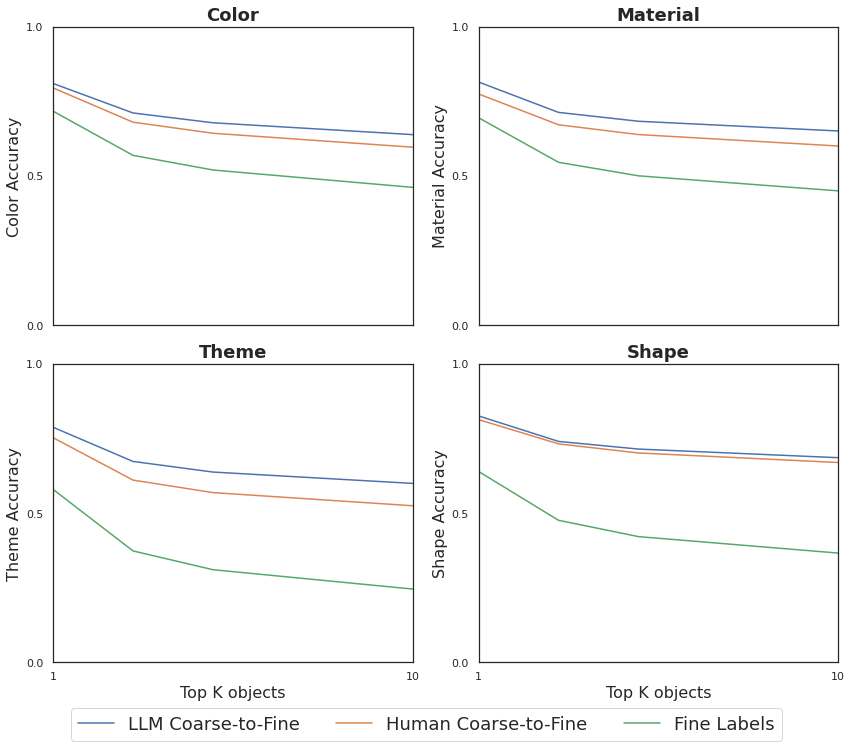

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Melting the DataFrame to long format
melted_df = pd.melt(df, id_vars=["Method"], var_name="Category_K", value_name="Category_Accuracy")
melted_df['K'] = melted_df['Category_K'].apply(lambda x: int(x.split('@')[1]))

# Plotting
sns.set(style="white")

categories = ['color', 'material', 'theme', 'shape']
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

for i, category in enumerate(categories):
    row = i // 2
    col = i % 2
    subset_df = melted_df[melted_df['Category_K'].str.startswith(category)]
    sns.lineplot(x="K", y="Category_Accuracy", hue="Method", data=subset_df, ax=axes[row, col])
    axes[row, col].set_title(f"{category.capitalize()}", fontsize=18, fontweight='bold')  # Increase title font size

    # Adjusting labels and limits
    axes[row, col].set_xlabel("Top K objects", fontsize=16)  # Increase x-label font size
    axes[row, col].set_ylabel(f"{category.capitalize()} Accuracy", fontsize=16)  # Increase y-label font size
    axes[row, col].set_xticks([1, 10])  # Setting only 1 and 10 on x-axis
    axes[row, col].set_yticks(np.arange(0, 1.1, step=0.5))
    axes[row, col].set_xlim(1, 10)
    axes[row, col].set_ylim(0, 1)

    # Remove individual legends
    axes[row, col].get_legend().remove()

# Flatten axes for a single legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=18, bbox_to_anchor=(0.5, -0.05), ncol=len(labels))  # Increase legend font size

plt.tight_layout()
plt.savefig("feature_accuracy_plots.svg", bbox_inches='tight', dpi=300)
plt.show()
